IMPORTING LIBRARIES AND DATASETS

In [ ]:
import pandas as pd # For Data Frame enablation 
import numpy as np  # For numerical analysis
import seaborn as sns # For visualization
import matplotlib.pyplot as plt # For visualization
import zipfile
import cv2 # used to deal with images
from skimage import io
import tensorflow as tf # using v2 and keras api to build all our model and train it
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/My Drive/Colab Notebooks/1st semester/Project/Brain_MRI

/content/drive/My Drive/Colab Notebooks/1st semester/Project/Brain_MRI


In [ ]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv') # putting data into brain_df so that will be a dataframe that contains all the data

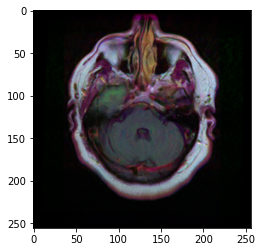

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

# in this code we are plotting the brain mri of patient 623
# if you look at the mri imaage you can find the green color which indicates the tumor

Training a classifier model (RESNET)  to detect if tumor exists or not

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

# sk_learn is a library for machine learning in python, it contains a lot of tools
# for machine learning and stastical modeling including classification,
# regression, clustering and dimensionality reduction
# model_selection is a method for setting a blueprint to analyze data and
# then using it to measure new data.
# 15% for testing and 85% for training

NameError: ignored

In [ ]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

# i am going to take the image and re-scale it/normalize it
# i am allocating 15% of normalized image to testing
# the testing data will be used to test the model after training is completed
# we are making sure our model is able to generalize and not memorize
# so what we do is that as we train the network we are gonna use is cross
# validation dataset to asses the performance of the train model as the training progress

In [ ]:
# in the above code we are taking train dataset into dataframe
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))
# the data generated above (datagen) is being used here with the help of flow_from_dataframe
# the first one is the train generator

# and also specifying directory with x_col and y_col with details like what they are
# we are feeding the images in batch_size of 16
# we will also shuffle this images as we flow this images from the directory
# this is important to make sure the model does not learn the actual order
# of my images thats why it is important to shuffle the data
# the class_mode is categorical, we can also use binary becasue we only have 2 classes
# the target_size wil be 256*256




valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# the 2nd one is valid generator
# in the above code we are taking train dataset into dataframe
# the above code has same explanation as for train one



# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)
# in the above code we are creating another generator for the testing data
# that is being used after the model is train
# note: for testing data we already have split the data in sklearn before even
# creating any of the generators
# so this code snippet will be the 15% of the entire dataset
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))
# here shuffle is false because i am testing them



# the third one is test genrator

# in the above code we have 2 subsets training one and validation one
# 2839 and 500 are the training and validation
# 590 will be the testing

in the below code we are applying transfer learning to load a pre-trained model

In [ ]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
# in the above code we are downloading the ResNet50 model
# and downloading the massive network imagenet
# network has been already pre-trained on million of images
# weights = 'imagenet' means i want to download the pre-trained network
# include_top = False means i dont want to include the dense layer at the end
# because i am going to add my own

In [ ]:
basemodel.summary()
# we have input layers, convolutional layers, batch_normalization, relu, pooling
# we are able to overcome vanishing gradient problem by having all these multiple
# layers stack on top of each other

we have 23 million parameters(weights) and trainable parameters are 23 million
and the non-trainable are 53k

In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

# in the above code we are setting all the layers in my base model i.e downloaded 
# right now and i want to freeze this weights
# i.e is done by layers.trainable = False which means i want to freeze them
# i am not gonna be training them

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)

headmodel = Dense(256, activation = "relu")(headmodel) # this is the dense layer which has 256 neurons and the activation function is relu
headmodel = Dropout(0.3)(headmodel) # adding droupout of 30%

headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)

#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)


# output
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)


# take my basemodel and averagepooling2d layer on top of it
# the next step is to flatten all the features
# and then i am going to add my dense fully connected artificial neural network
# droupout is generally used to improve the generalization capability of my model
# we are droping 30% of the neurons randomly and their connected weights and the
# idea here is as we train that we actually perform that the network or the
# neurons start to develop co-dependency among them and by applying droupout
# you will be able to remove the co-dependency which means all of these neurons

# we have another dense layer and we have another droupout
# at the output we have 2 neurons and these 2 neurons will simply gonna have
# if there a tumor or not
# the activation function in the output will be a softmax activation function

# after that i have created a model that consists of my base model along with the
# outputs = headmodel that we just created above

# why specifically we add 256 neurons and additional dense layer
# all of that is trial and error we can add an additional dense layer
# and we can change the activation function we can do a lot of experimentation
# in here

In [ ]:
model.summary()

now i have my new network and these are the new layers that we added, we have our average_pooling layer,flatten layer,dense, droupout, dense, droupout and in last output(dense_2)
and now the number of parameters is 25 million

In [ ]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# if the validation loss did not improve we need to do an early stopping
# just exit the training process if it doesn't improve for 20 epochs
# so we want to make sure that error on the training data and error on the validation
# data both of them are going down thats a good sign that means the network is able
# to generalize however if you reach a state where error on the training data
# is going down and erorr on the validation data is going up that means now
# the network starts to memorize the training data and it will fail to generalize
# so we will stop the training

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)
# classifier-resnet-weights.hdf5 these are the actual train parameters

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

# fitting the model with the training data and specifying how many epochs we are looking for(1)
# showing the performance of the network just within 1 epoch only
# while running the cell we can see the accuracy of our new model
# here we have new brain images the model has never seen this images before
# but because we started from pre-trained model on the imagenet-dataset
# the model was able to achieve some accuracy and never even started the training yet


In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# classifier-resnet-model.json architecture of the model in the json format

we can also tweak the architecture of the model by adding more dense layers

in below code snipets we are assessing the trained model performance

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file: #architecture capture in the json format
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5') # we are loading actual weights of the model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

# all the inteligience we need is captured in the model

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

# applying predict method on my model and feeding the test_generator
# feeding the data the model has never seen before during training

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

 # the output here has 2 neurons
# we can have 1 single neuron that could generate either 0 or 1
# or we can have 2 neurons and we can then pick out the max out of both of them
# which tell does it belong to class no. 1 or class no. 2

In [ ]:
predict

in the above output we have bunch of 0's and 1's, so basically we need to compare the actual predictions from my model to my originally ground truth label

in the below code we are checking accuracy of the predicted model and original model

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

# we are going to testing data and in it mask column
# here we have the original(ground truth)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

# original vs predicted

in the above output we have obtained the 98% accuracy on the testing data
which is simply the data the model has never seen before during training

# Resunet

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape
# getting data has mask associated with it
# i.e selecting data having tumor

In [ ]:
# split the data into train,test and validation data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)

# dividing brain_df into X_train and X_val 



X_test, X_val = train_test_split(X_val, test_size=0.5)

# taking X_val and dividing it into X_test and X_val

# in the end we have training validation and testing data

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

# training resunet with inputs and outputs
# the input will be the mri image and the output will be mask associated
# with that image
# the input and output have the same size

# so here we are taking the x_train.image_path that would be my inputs
# and the output will simply the mask associated with that image

# the same will be repeated for validation data

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  
  # Short path
  
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X


# the first part in building resunet is to build the res-block
# basically there are 2 paths the first one is the main path
# the 2nd one is the short path

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1-4 (encoder path)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)

conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)

pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


# The above code could be understood by looking at the Resunet architecture
# every step is coded

In [ ]:
model_seg.summary()

Training Resunet model
We need a custom loss function to train this ResUNet.So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

# we need a custom loss function to perform pixel-level segmentation

In [ ]:
# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# patience = 20 ensures we are not overfitting the training data

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)


Assessing the trained segmentation resunet model performance

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

# loading a pre-trained model(resunet-mri.jason) and load weights(weights_seg.hdf5)
# the next thing we will be using is adam optimiser
# and compile the model afterwards

In [ ]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

# predict function is provided with a testing data and 2 models
# Resnet and resunet if there is a tumor it will be fed to model_seg

# if we run this cell it will return back the image_id,mask and
# tell me if there is mask or not

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

In [ ]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50)) # 10 numbers of images
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()